## Solving the Convection-Dominated Heat Equation with Standard CG

We consider the **convection-dominated heat equation**:

$$
\partial_t u - \varepsilon \, \partial_{xx} u + w \, \partial_x u = f
$$

as a test case for the limitations of standard continuous Galerkin (CG) methods in convection-dominated regimes.

### Problem Setup

We define the exact solution as:

$$
u(x,t) = \phi(x) \cdot e^{-t}
$$

with

$$
\phi(x) = \frac{1 - \exp\left(\frac{x - 1}{\varepsilon}\right)}{1 - \exp\left(-\frac{1}{\varepsilon}\right)}
$$

This profile features a sharp boundary layer near \( x = 1 \) for small \( \varepsilon \), making it a suitable test for numerical stabilization techniques.

### Forcing Term

To match this exact solution, we compute:

- $$ \partial_t u = -\phi(x) \cdot e^{-t} $$
- $$ \partial_x u = \phi'(x) \cdot e^{-t} $$
- $$ \partial_{xx} u = \phi''(x) \cdot e^{-t} $$

where:

$$
\phi'(x) = \frac{1}{\varepsilon} \cdot \frac{\exp\left(\frac{x - 1}{\varepsilon}\right)}{1 - \exp\left(-\frac{1}{\varepsilon}\right)}, \quad
\phi''(x) = \frac{1}{\varepsilon^2} \cdot \frac{\exp\left(\frac{x - 1}{\varepsilon}\right)}{1 - \exp\left(-\frac{1}{\varepsilon}\right)}
$$

Thus, the forcing term becomes:

$$
f(x,t) = -\phi(x) \cdot e^{-t}
$$

### Initial Condition

At time \( t = 0 \), the initial condition is:

$$
u(x,0) = \phi(x)
$$

This setup allows us to examine the numerical behavior of CG schemes in the presence of strong convection and steep gradients.


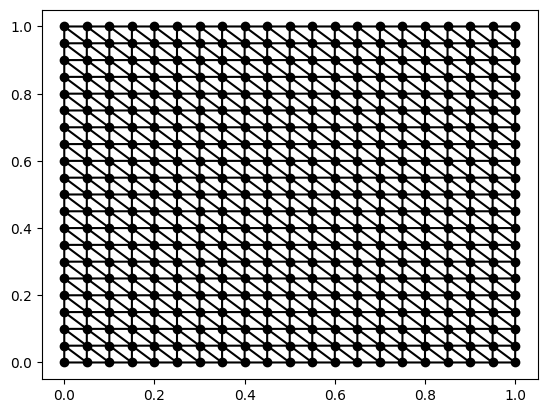

In [10]:
from import_hack import *
from methodsnm.mesh_2d import *
from methodsnm.visualize import *
from methodsnm.solver import solve_on_freedofs
from methodsnm.forms import *
from methodsnm.formint import *
import numpy as np
from numpy import pi, sin, cos, exp

def list_diff(a, b):
    """Entfernt alle Elemente aus Liste a, die in Liste b enthalten sind."""
    return [x for x in a if x not in b]
mesh = StructuredRectangleMesh(20, 20)
DrawMesh2D(mesh)

from methodsnm.fes import *
fes = P1_Triangle_Space(mesh)

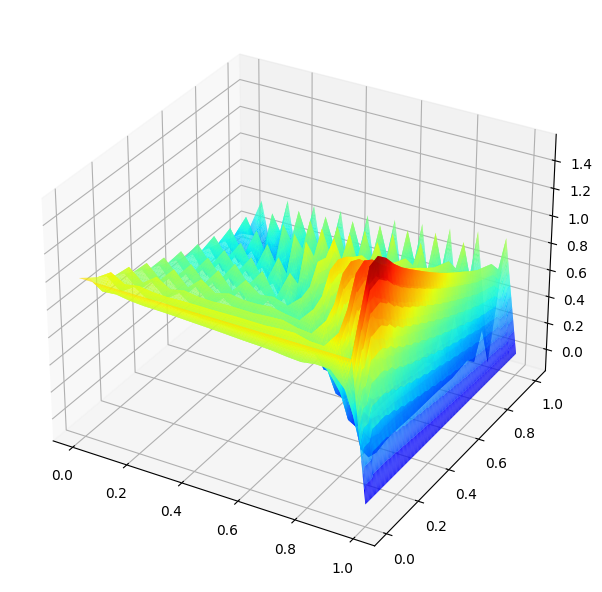

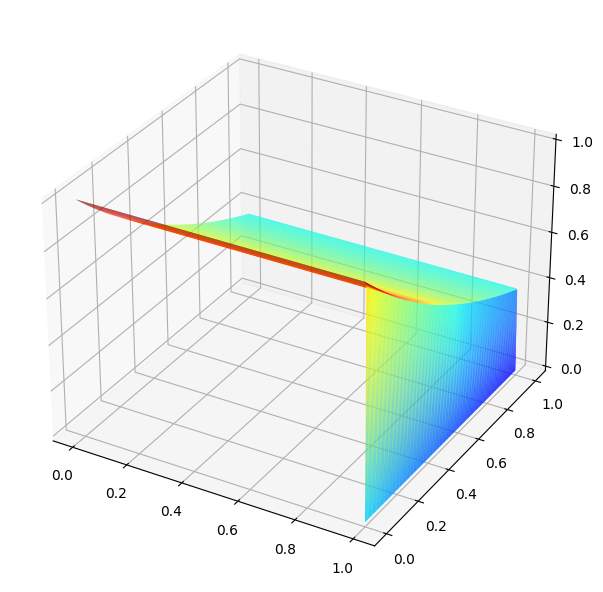

l2diff = 0.17931006269611335


In [13]:
epsi = 0.001
wind =1
eps = GlobalFunction(lambda x: epsi, mesh = mesh)
w = ConstantVectorFunction(np.array([wind,1]), mesh = mesh)

blf = BilinearForm(fes)
blf += LaplaceIntegral_without_time(eps)
blf += ConvectionIntegral(w)
blf.assemble()

f = lambda x: -(1 - exp((x[0] - 1)/epsi)) / (1 - exp(-1/epsi))* exp(-x[1])
f = GlobalFunction(f, mesh = mesh)
lf = LinearForm(fes)
lf += SourceIntegral(f)
lf.assemble()

top = mesh.filter_bndry_points("max",1)
bottom = mesh.filter_bndry_points("min",1)
left = mesh.filter_bndry_points("min",0)
right = mesh.filter_bndry_points("max",0)
bndry = left + right + bottom
freedofs = list_diff(mesh.vertices,bndry)

uex = lambda x: (1 - exp((x[0] - 1)/epsi)) / (1 - exp(-1/epsi))* exp(-x[1])
uh = FEFunction(fes)
uh._set(uex, bndry)

res = lf.vector - blf.matrix.dot(uh.vector)
uh.vector += solve_on_freedofs(blf.matrix,res,freedofs)
from methodsnm.forms import compute_difference_L2
u_exact = GlobalFunction(uex, mesh = mesh)
l2diff = compute_difference_L2(uh, u_exact, mesh, intorder = 5)

DrawFunction2D(uh)
DrawFunction2D(u_exact)
print("l2diff =", l2diff)

# Now let us add an SUPG-stabilization term

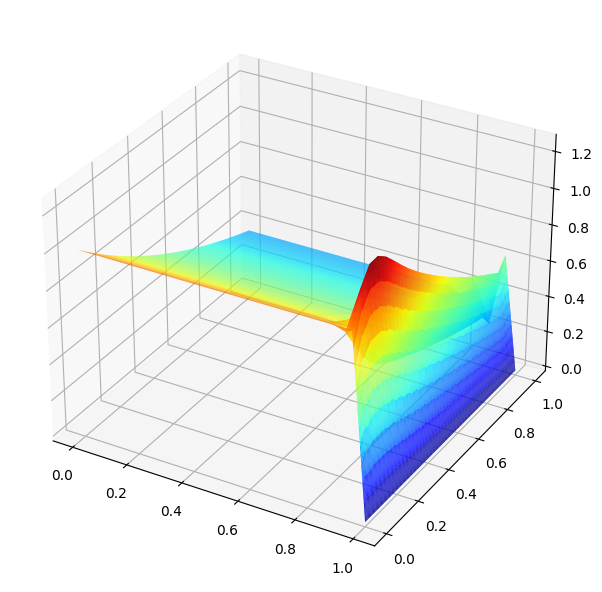

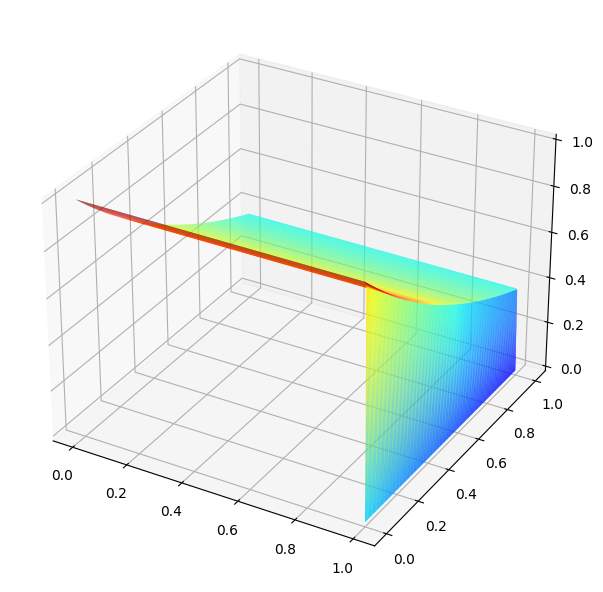

l2diff = 0.08252908764134606


In [14]:
blf += SUPGIntegral(w)
blf.assemble()

lf += SUPGSourceIntegral(f, w)
lf.assemble()

uh = FEFunction(fes)
uh._set(uex, bndry)

res = lf.vector - blf.matrix.dot(uh.vector)
uh.vector += solve_on_freedofs(blf.matrix,res,freedofs)
from methodsnm.forms import compute_difference_L2
u_exact = GlobalFunction(uex, mesh = mesh)
l2diff = compute_difference_L2(uh, u_exact, mesh, intorder = 5)

DrawFunction2D(uh)
DrawFunction2D(u_exact)
print("l2diff =", l2diff)